## Generating fixtures to test the Equation Of Time functions, the Longitude Fitting Functions and the Longitude Calculation Functions

### Expected Longitude Output is downloaded directly from https://maps.nrel.gov/pvdaq/ PVDAQ Contributed Sites

### Expected longitude = -76.6636

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np
# PVInsight Code Imports
from solardatatools import DataHandler
from solardatatools.dataio import get_pvdaq_data
path = Path.cwd().parent.parent.parent
os.chdir(path)

### Load data table from external source

#### For today's example, we're loading data from NREL's PVDAQ API, which is a publically available PV generatation data set.

In [3]:
latitude = 39.4856
longitude = -76.6636
tilt = 20
azimuth = 180
gmt_offset = -5

In [4]:
data_frame = get_pvdaq_data(sysid=1199, year=[2015, 2016, 2017], api_key='DEMO_KEY')

[============================================================] 100.0% ...queries complete in 20.9 seconds       

CAUTION: Multiple scan rates detected!
Scan rates (in seconds): [300, 280]
0 transitions detected.
Suggest splitting data set between:




In [5]:
gmt_offset = -5

### Running the  DataHandler

In [6]:
dh = DataHandler(data_frame)
dh.fix_dst()

In [7]:
dh.run_pipeline(power_col='ac_power', fix_shifts=False, correct_tz=False)

total time: 3.30 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              1.29s
Cleaning                   0.07s
Filtering/Summarizing      1.94s
    Data quality           0.07s
    Clear day detect       0.08s
    Clipping detect        1.48s
    Capacity change detect 0.30s



In [8]:
days = dh.daily_flags.no_errors

In [9]:
day_of_year = dh.day_index.dayofyear

In [10]:
day_range = np.ones(day_of_year.shape, dtype=bool)

In [11]:
daily_meas = dh.filled_data_matrix.shape[0]

In [12]:
daytime_threshold = None

In [13]:
# exporting inputs for tilt and azimuth estimation
#day_of_year
#np.savetxt('./tests/fixtures/tilt_azimuth/day_of_year.csv', day_of_year,  delimiter=",")
# days
#np.savetxt('./tests/fixtures/tilt_azimuth/days.csv', days,  delimiter=",")
#day range
# days
#np.savetxt('./tests/fixtures/tilt_azimuth/day_range.csv', day_range,  delimiter=",")

## Calculate cosine of angle of incidence

In [14]:
from pvsystemprofiler.algorithms.performance_model_estimation import find_fit_costheta

In [15]:
scale_factor_costheta, costheta_fit = find_fit_costheta(dh.filled_data_matrix, dh.daily_flags.no_errors, day_of_year)

In [16]:
# exporting inputs for tilt and azimuth estimation
# costheta_fit
# np.savetxt('./tests/fixtures/tilt_azimuth/costheta_fit.csv', costheta_fit,  delimiter=",")

## Find hours daylight

In [17]:
from pvsystemprofiler.algorithms.latitude.hours_daylight import calculate_hours_daylight

In [18]:
from solardatatools.algorithms import SunriseSunset

In [19]:
ss = SunriseSunset()

In [20]:
ss.run_optimizer(data=dh.filled_data_matrix)

In [21]:
hours_daylight = ss.sunset_estimates - ss.sunrise_estimates

In [22]:
# exporting inputs for tilt and azimuth estimation
# hours_daylight
#np.savetxt('./tests/fixtures/tilt_azimuth/hours_daylight.csv', hours_daylight,  delimiter=",")

## Calculate boolean filter

In [23]:
from pvsystemprofiler.algorithms.tilt_azimuth.daytime_threshold_quantile import filter_data

In [24]:
boolean_filter = filter_data(dh.filled_data_matrix, daytime_threshold=daytime_threshold, x1=0.9, x2=0.9)

In [25]:
boolean_filter = boolean_filter * days * day_range

In [26]:
from pvsystemprofiler.utilities.hour_angle_equation import calculate_omega

In [27]:
# exporting inputs for tilt and azimuth estimation
# boolean_filter
# np.savetxt('./tests/fixtures/tilt_azimuth/boolean_filter.csv', boolean_filter,  delimiter=",")

## Calculate hour angle

In [28]:
omega = calculate_omega(day_of_year, dh.data_sampling, longitude, gmt_offset)

In [29]:
omega_f = omega[boolean_filter]

In [30]:
# exporting inputs for tilt and azimuth estimation
# omega_f
# np.savetxt('./tests/fixtures/tilt_azimuth/omega_f.csv', omega_f,  delimiter=",")

## Calculate declination

In [31]:
from pvsystemprofiler.utilities.declination_equation import delta_cooper

In [32]:
delta = delta_cooper(day_of_year, daily_meas)

In [33]:
delta_f = delta[boolean_filter]

In [34]:
# exporting inputs for tilt and azimuth estimation
# delta_f
# np.savetxt('./tests/fixtures/tilt_azimuth/delta_f.csv', delta_f,  delimiter=",")

## Estimate tilt and azimuth using run_curve_fit directly

In [35]:
from pvsystemprofiler.algorithms.angle_of_incidence.lambda_functions import select_function

In [36]:
func_customized, bounds = select_function(latitude, None, None)

In [37]:
from pvsystemprofiler.algorithms.angle_of_incidence.curve_fitting import run_curve_fit

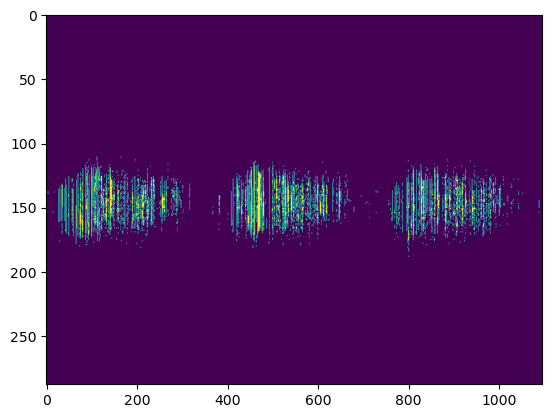

In [43]:
import matplotlib.pyplot as plt
plt.imshow(boolean_filter, aspect='auto');

In [45]:
estimates = run_curve_fit(func=func_customized, keys=['tilt', 'azimuth'], delta=delta_f, omega=omega_f,
                                  costheta=costheta_fit, boolean_filter=None, init_values=[30, 30],
                                  fit_bounds=bounds)

ValueError: operands could not be broadcast together with shapes (9916,) (1,1096) 

In [ ]:
estimates[1]

## Estimate tilt and azimuth using the ConfigurationEstimator class

In [ ]:
from pvsystemprofiler.estimator import ConfigurationEstimator

In [ ]:
est = ConfigurationEstimator(dh, gmt_offset=-5)

In [ ]:
est.estimate_orientation(longitude=longitude, latitude=latitude)

In [ ]:
latitude

In [ ]:
est.tilt

In [ ]:
est.azimuth